## Imports

In [43]:
from utils import vmt_utils
from utils import regression
import matplotlib.pyplot as plt
import numpy as np
import copy
import time
import os
import nibabel as nib
# import h5py
import cPickle

In [44]:
%matplotlib inline

In [45]:
reload(regression)

<module 'utils.regression' from 'utils/regression.pyc'>

## Get masked data

In [46]:
data = np.load('../data/masked_data_50k.npy')

In [47]:
data.shape

(55468, 3543)

(array([  5.47290000e+04,   5.44000000e+02,   1.21000000e+02,
          4.20000000e+01,   1.90000000e+01,   8.00000000e+00,
          1.00000000e+00,   2.00000000e+00,   1.00000000e+00,
          1.00000000e+00]),
 array([      0.        ,   21262.41620456,   42524.83240912,
          63787.24861368,   85049.66481824,  106312.0810228 ,
         127574.49722736,  148836.91343192,  170099.32963648,
         191361.74584104,  212624.1620456 ]),
 <a list of 10 Patch objects>)

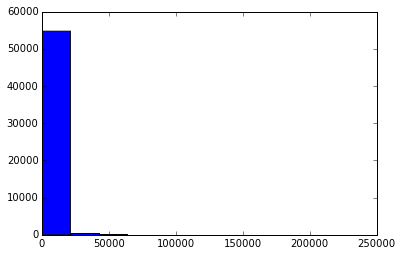

In [48]:
plt.hist(np.var(data,axis=1))

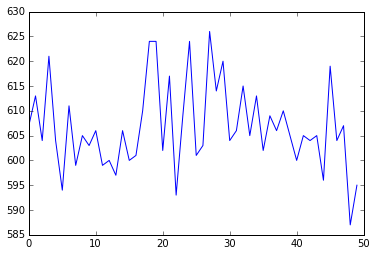

In [23]:
plt.plot(data[16188,:50])

## Get feature space

In [49]:
# Get stimulus feature spaces
stim_fs_fpath = '../description_pp/design_matrix_1.npy'
stim_fs_file = np.load(stim_fs_fpath)
stim_fs_file = stim_fs_file[:3543,:]

In [50]:
stim_fs_file.shape

(3543, 1155)

## Separate Trainig and testing data

In [51]:
e, v = 3000, 543

In [52]:
stim_fs_est = stim_fs_file[:e,:]
stim_fs_val = stim_fs_file[:v,:]

In [53]:
print('Estimation feature space shape: %s'%repr(stim_fs_est.shape))
print('Validation feature space shape: %s'%repr(stim_fs_val.shape))

Estimation feature space shape: (3000, 1155)
Validation feature space shape: (543, 1155)


In [54]:
data_est = data[...,:e]
data_val = data[...,:v]

In [55]:
data_est_masked = data_est.T
data_val_masked = data_val.T
# Show size of masked data
print('Size of masked estimation data is %s'%repr(data_est_masked.shape))
print('Size of masked validation data is %s'%repr(data_val_masked.shape))

Size of masked estimation data is (3000, 55468)
Size of masked validation data is (543, 55468)


## Set up feature space matrix to do regression

In [56]:
# Create lagged stimulus matrix
efs = vmt_utils.add_lags(stim_fs_est,[2,3,4])
vfs = vmt_utils.add_lags(stim_fs_val,[2,3,4])
# Add column of ones
efs = vmt_utils.add_constant(efs,is_first=True)
vfs = vmt_utils.add_constant(vfs,is_first=True)

# Subset data and stimuli

In [63]:
ts = 1000 #training subset
es = 143 #estimation subset

In [64]:
efs = efs[:ts,:]
vfs = vfs[:es,:]
print efs.shape
print vfs.shape

(1000, 3466)
(143, 3466)


In [65]:
data_est_masked = data_est_masked[:ts,:]
data_val_masked = data_val_masked[:es,:]
print data_est_masked.shape
print data_val_masked.shape

(1000, 55468)
(143, 55468)


## Run regression

In [66]:
reload(vmt_utils)

<module 'utils.vmt_utils' from 'utils/vmt_utils.pyc'>

In [67]:
alpha = np.logspace(0,6,10)
alpha

array([  1.00000000e+00,   4.64158883e+00,   2.15443469e+01,
         1.00000000e+02,   4.64158883e+02,   2.15443469e+03,
         1.00000000e+04,   4.64158883e+04,   2.15443469e+05,
         1.00000000e+06])

In [68]:
# Run regression 
n_splits = 10 # number of subdivisions of validation data for cross validation of ridge parameter (alpha)
n_resamps = 10 # number of times to compute regression & prediction within training data (can be <= n_splits)
chunk_sz = 6000 # number of voxels to fit at once. Memory-saving.
pthr = 0.005 # Ridge parameter is chosen based on how many voxels are predicted above a correlation threshold 
             # for each alpha value (technically it's slightly more complicated than that, see the code). 
             # This p value sets that correlation threshold.
t0 = time.time()

out = regression.ridge_cv(efs,data_est_masked,val_fs=vfs,val_data=data_val_masked,alphas=alpha,n_resamps=n_resamps,
                              n_splits=n_splits,chunk_sz=chunk_sz,pthr=pthr,is_verbose=True)

t1 = time.time()
print("Elapsed time is: %d min, %d sec"%((t1-t0)/60,(t1-t0)%60))

Running split 1/10
Running chunk 1 of 10...

Running chunk 2 of 10...

Running chunk 3 of 10...

Running chunk 4 of 10...

Running chunk 5 of 10...

Running chunk 6 of 10...

Running chunk 7 of 10...

Running chunk 8 of 10...

Running chunk 9 of 10...

Running chunk 10 of 10...

Running split 2/10
Running chunk 1 of 10...

Running chunk 2 of 10...

Running chunk 3 of 10...

Running chunk 4 of 10...

Running chunk 5 of 10...

Running chunk 6 of 10...

Running chunk 7 of 10...

Running chunk 8 of 10...

Running chunk 9 of 10...

Running chunk 10 of 10...

Running split 3/10
Running chunk 1 of 10...

Running chunk 2 of 10...

Running chunk 3 of 10...

Running chunk 4 of 10...

Running chunk 5 of 10...

Running chunk 6 of 10...

Running chunk 7 of 10...

Running chunk 8 of 10...

Running chunk 9 of 10...

Running chunk 10 of 10...

Running split 4/10
Running chunk 1 of 10...

Running chunk 2 of 10...

Running chunk 3 of 10...

Running chunk 4 of 10...

Running chunk 5 of 10...

Running chu

utils/regression.py:206: RuntimeWarning: invalid value encountered in greater
  n_sig_vox_byalpha = sum(trncc_byvox>sig_thresh)-sum(trncc_byvox<-sig_thresh)
utils/regression.py:206: RuntimeWarning: invalid value encountered in less
  n_sig_vox_byalpha = sum(trncc_byvox>sig_thresh)-sum(trncc_byvox<-sig_thresh)



Best alpha = 1.000
Computing weights and model predictions...
Running chunk 1 of 10...

Running chunk 2 of 10...

Running chunk 3 of 10...

Running chunk 4 of 10...

Running chunk 5 of 10...

Running chunk 6 of 10...

Running chunk 7 of 10...

Running chunk 8 of 10...

Running chunk 9 of 10...

Running chunk 10 of 10...

Elapsed time is: 3 min, 19 sec


## Make sure estimation procedure chose a reasonable $\alpha$ value
There should be a somewhat obvious maximum in the curve plotted below

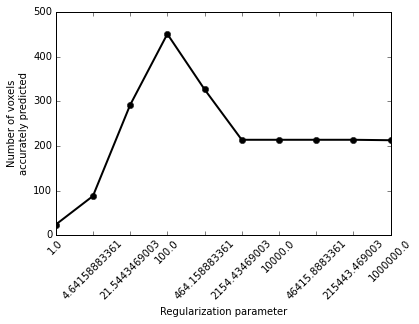

In [47]:
# Plot number of voxels with significant prediction accuracy within the 
# estimation data for each alpha value
na = len(out['n_sig_vox_byalpha'])
plt.plot(range(na),out['n_sig_vox_byalpha'],'ko-',lw=2)
# plt.xticks(range(na),vmt.regression.DEFAULT_ALPHAS,rotation=45)
plt.xticks(range(na),alpha,rotation=45)
plt.xlabel('Regularization parameter')
_ = plt.ylabel('Number of voxels\naccurately predicted')

## Display prediction accuracy results on the cortical surface

In [48]:
out['cc'].shape

(55468,)

In [49]:
cc = out['cc']
weights = out['weights']

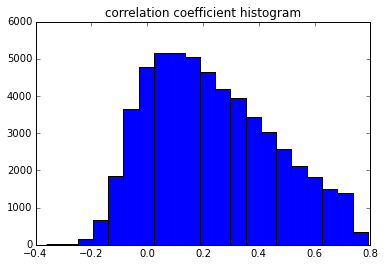

In [50]:
plt.hist(np.nan_to_num(cc),21)
plt.title('correlation coefficient histogram')

In [51]:
out['weights'].shape

(3466, 55468)

In [52]:
voxel_idx = np.argsort(cc)[::-1][:100]
voxel_idx

array([15656, 16827, 16614, 16627, 14954, 14956, 16634, 15988, 15984,
       15977, 19438, 19420, 19408, 14965, 16796, 16811, 21906, 16599,
       16598, 16412, 16163, 16189, 16184, 14615, 16175, 14635, 14600,
       14589, 16405, 14224, 14196, 21169, 14174, 14162, 16391, 19945,
       16820, 16960, 16971, 18589, 17077, 15459, 20532, 20514, 15463,
       15468, 15473, 17083, 17117, 17121, 17181, 15642, 15646, 15651,
       18604, 19931, 18985, 15254, 15249, 17071, 18967, 14976, 15814,
       15820, 15261, 15245, 15824, 15829, 19002, 16978, 14990, 37221,
       48350, 21372, 20077,  8954, 20704,    84, 15619, 42948, 22883,
       43843,  8955, 37247, 49219,  4925,  8210,   461, 43660,  1129,
       19106, 46249, 48780,  5530, 36402,  2572, 38047,  8193, 54572,  3663])

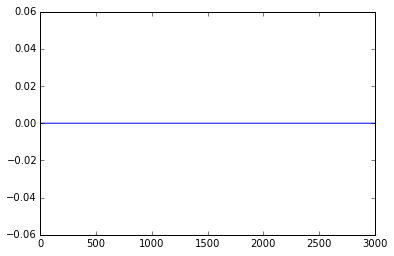

In [61]:
plt.plot(data_est_masked[:,16184])

In [62]:
np.var(data_est_masked[:,16184])

0.0

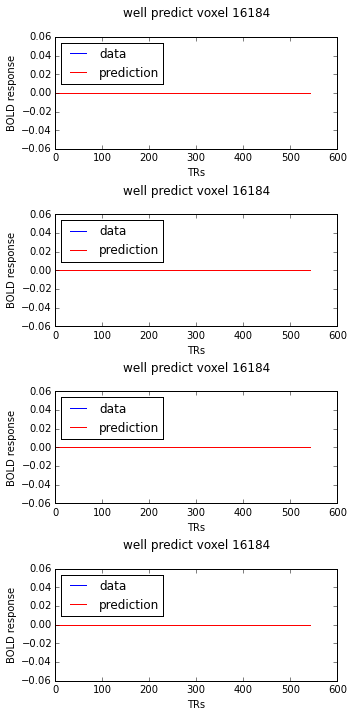

In [59]:
plt.figure(figsize=(5,10))
for n in range(4):
#     i = voxel_idx[15656]
    i=16184
    pred_activity = vfs.dot(weights[:,i])
    plt.subplot(4,n//4+1,n%4+1)
    l1, = plt.plot(data_val_masked[:,i],'b')
    l2, = plt.plot(pred_activity,'r')
    plt.ylabel('BOLD response')
    plt.xlabel('TRs')
    plt.title('well predict voxel %d\n'%i)
    plt.legend([l1, l2], ['data','prediction'],loc=2)
    
plt.tight_layout()

In [243]:
data_est_masked.shape

(1200, 34589)

In [213]:
sum(cc>0.6)

28432